## Imports

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from utils import load_images, plot_confusion_matrix

## Parameters

In [187]:
N_BREEDS = 2
STD_SIZE = (500, 375)

ENVIRONNEMENT = 'local'
if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/Data/'
else:
    PATH = 'images/'

params = {
    'filter': None,
    'box_size': 3,  # Used only with mean, gaussian and median filter
    'n_clusters': 75*N_BREEDS,
}

## Load images

In [115]:
images_orig, y = load_images(PATH, N_BREEDS, STD_SIZE)

Loaded 1/2: 152 images for breed: Chihuahua
Loaded 2/2: 185 images for breed: Japanese_spaniel


## Apply filter

In [188]:
images = np.array(images_orig)
if params['filter'] == 'equalize':
    images = [cv2.equalizeHist(img) for img in images]
if params['filter'] == 'mean':
    images = [cv2.blur(img, (params['box_size'], params['box_size'])) for img in images]
if params['filter'] == 'gaussian':
    images = [cv2.GaussianBlur(img, (params['box_size'], params['box_size']), 0) for img in images]
if params['filter'] == 'median':
    images = [cv2.medianBlur(img, params['box_size']) for img in images]
if params['filter'] == 'non-local':
    images = [cv2.fastNlMeansDenoising(img) for img in images]
if params['filter'] == 'whitening':   
    images = np.array(images_orig)
    images_temp = images.reshape(images.shape[0], -1)
    images_temp = images_temp - images_temp.mean(axis=0)
    cov = np.cov(images_temp, rowvar=True)
    U, S, V = np.linalg.svd(cov)
    epsilon = 1e-1
    images_ZCA = np.dot(np.dot(U, np.dot(np.diag(1.0 / np.sqrt(S + epsilon)), U.T)), images_temp)
    images_ZCA_rescaled = 255 * (images_ZCA - images_ZCA.min()) / (images_ZCA.max() - images_ZCA.min())
    images = images_ZCA_rescaled.reshape(images.shape[0], 375, 500).astype('uint8') 
images = np.array(images)
print(f"Images pre-processed with {params['filter']} filter")

Images pre-processed with None filter


## Train/test split

In [189]:
images_train, images_test, y_train, y_test = train_test_split(images, y, test_size=0.20, stratify=y, random_state=0)

## Extract SIFT features

In [190]:
sift = cv2.xfeatures2d_SIFT.create()
descriptors = []
for image in images_train:
    kp, desc = sift.detectAndCompute(image, None)
    descriptors.extend([x for x in desc])
print(f'{len(descriptors)} SIFT descriptors detected over {images_train.shape[0]} images')

272515 SIFT descriptors detected over 269 images


## KMeans clustering

In [191]:
kmeans = MiniBatchKMeans(n_clusters=params['n_clusters'], batch_size=10000, random_state=0)
kmeans.fit(descriptors)
print(f'KMeans clustering with {params["n_clusters"]} clusters')

KMeans clustering with 150 clusters


## Inputs

In [192]:
X_train = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
X_test = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
for image in images_train:
    kp, desc = sift.detectAndCompute(image, None)
    labels = kmeans.predict(pd.DataFrame(desc))
    unique, counts = np.unique(labels, return_counts=True)
    X_train = X_train.append(dict(zip(unique, counts)), ignore_index=True)
for image in images_test:
    kp, desc = sift.detectAndCompute(image, None)
    labels = kmeans.predict(pd.DataFrame(desc))
    unique, counts = np.unique(labels, return_counts=True)
    X_test = X_test.append(dict(zip(unique, counts)), ignore_index=True)

X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

## Output

In [193]:
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

## Train classifier (CV)

Fitting 4 folds for each of 21 candidates, totalling 84 fits


[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.5s finished


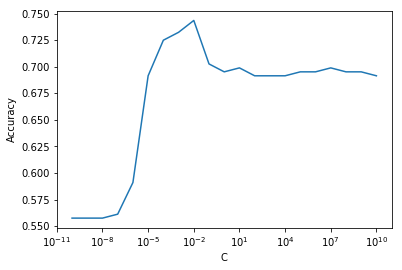

In [194]:
param_grid = {'C': np.logspace(-10, 10, 21)}
model = GridSearchCV(LogisticRegression(), param_grid, cv=4, scoring='accuracy', verbose=1)
model.fit(X_train, y_train)

plt.semilogx(model.param_grid['C'], model.cv_results_['mean_test_score'])
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.show()

y_pred = model.predict(X_test)

## Results

### Baseline

----- Accuracy: 75.00 % -----
Filter: None (box size: 9 - only relevant for mean, gaussian and median filters)
Normalization: False
n_clusters: 150


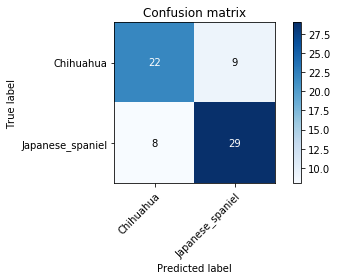

In [68]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'Normalization: {params["normalization"]}')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

### Equalization

----- Accuracy: 72.06 % -----
Filter: equalize (box size: 9 - only relevant for mean, gaussian and median filters)
Normalization: False
n_clusters: 150


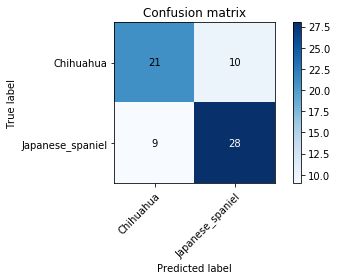

In [77]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'Normalization: {params["normalization"]}')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

### Averaging

----- Accuracy: 73.53 % -----
Filter: mean (box size: 5 - only relevant for mean, gaussian and median filters)
Normalization: False
n_clusters: 150


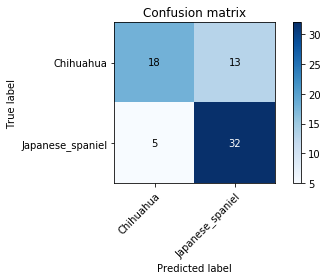

In [113]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'Normalization: {params["normalization"]}')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

### Gaussian filter

----- Accuracy: 70.59 % -----
Filter: gaussian (box size: 3 - only relevant for mean, gaussian and median filters)
Normalization: False
n_clusters: 150


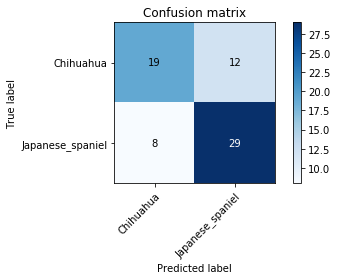

In [141]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'Normalization: {params["normalization"]}')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

### Median filter

----- Accuracy: 67.65 % -----
Filter: median (box size: 3 - only relevant for mean, gaussian and median filters)
Normalization: False
n_clusters: 150


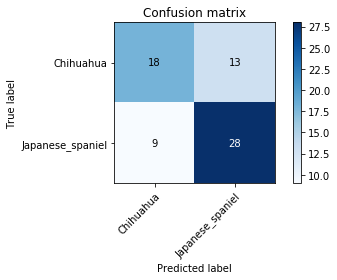

In [168]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'Normalization: {params["normalization"]}')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

### Non-local means filter

----- Accuracy: 70.59 % -----
Filter: non-local (box size: 9 - only relevant for mean, gaussian and median filters)
Normalization: False
n_clusters: 150


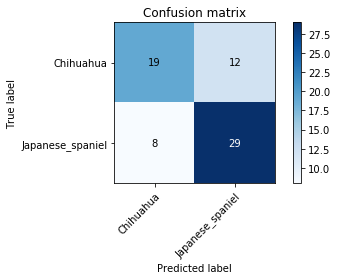

In [86]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'Normalization: {params["normalization"]}')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

### ZCA whitening 

----- Accuracy: 58.82 % -----
Filter: whitening (box size: 9 - only relevant for mean, gaussian and median filters)
Normalization: False
n_clusters: 150


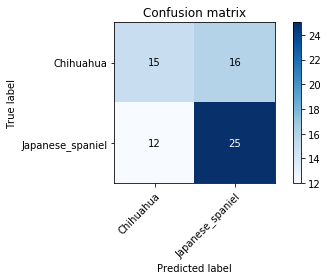

In [95]:
print(f'----- Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f} % -----')
print(f'Filter: {params["filter"]} (box size: {params["box_size"]} - only relevant for mean, gaussian and median filters)')
print(f'Normalization: {params["normalization"]}')
print(f'n_clusters: {params["n_clusters"]}')

plot_confusion_matrix(y_test, y_pred, le.classes_)
plt.show()

### Number of clusters

In [39]:
mean_test_score = dict()
accuracies = dict()
for n_clusters in [10, 20, 50, 100]:
    print(f"Starting to test n_clusters = {n_clusters}")
    params["n_clusters"] = n_clusters
    accuracies[n_clusters] = []
    for i in range(10):
        kmeans = MiniBatchKMeans(n_clusters=params["n_clusters"], batch_size=10000)
        kmeans.fit(descriptors)
        X_train = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
        X_test = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
        for image in images_train:
            kp, desc = sift.detectAndCompute(image, None)
            labels = kmeans.predict(pd.DataFrame(desc))
            unique, counts = np.unique(labels, return_counts=True)
            X_train = X_train.append(dict(zip(unique, counts)), ignore_index=True)
        for image in images_test:
            kp, desc = sift.detectAndCompute(image, None)
            labels = kmeans.predict(pd.DataFrame(desc))
            unique, counts = np.unique(labels, return_counts=True)
            X_test = X_test.append(dict(zip(unique, counts)), ignore_index=True)
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)
        le = LabelEncoder().fit(y_train)
        y_train = le.transform(y_train)
        y_test = le.transform(y_test)
        param_grid = {'C': np.logspace(-10, 10, 21)}
        model = GridSearchCV(LogisticRegression(), param_grid, cv=4, scoring='accuracy', verbose=0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"Run n°{i+1} - Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}")
        accuracies[n_clusters].append(accuracy_score(y_test, y_pred))
    mean_test_score[n_clusters] = np.mean(accuracies[n_clusters])
    

Starting to test n_clusters = 10
Run n°1 - Accuracy: 54.41
Run n°2 - Accuracy: 61.76
Run n°3 - Accuracy: 58.82
Run n°4 - Accuracy: 70.59
Run n°5 - Accuracy: 63.24
Run n°6 - Accuracy: 54.41
Run n°7 - Accuracy: 63.24
Run n°8 - Accuracy: 72.06
Run n°9 - Accuracy: 69.12
Run n°10 - Accuracy: 61.76
Starting to test n_clusters = 20
Run n°1 - Accuracy: 63.24
Run n°2 - Accuracy: 67.65
Run n°3 - Accuracy: 64.71
Run n°4 - Accuracy: 73.53
Run n°5 - Accuracy: 69.12
Run n°6 - Accuracy: 61.76
Run n°7 - Accuracy: 64.71
Run n°8 - Accuracy: 64.71
Run n°9 - Accuracy: 73.53
Run n°10 - Accuracy: 61.76
Starting to test n_clusters = 50
Run n°1 - Accuracy: 66.18
Run n°2 - Accuracy: 73.53
Run n°3 - Accuracy: 66.18
Run n°4 - Accuracy: 70.59
Run n°5 - Accuracy: 69.12
Run n°6 - Accuracy: 69.12
Run n°7 - Accuracy: 67.65
Run n°8 - Accuracy: 64.71
Run n°9 - Accuracy: 72.06
Run n°10 - Accuracy: 61.76
Starting to test n_clusters = 100
Run n°1 - Accuracy: 67.65
Run n°2 - Accuracy: 73.53
Run n°3 - Accuracy: 70.59
Run n°

In [49]:
print(accuracies)
print("\n", mean_test_score)

{10: [0.5441176470588235, 0.6176470588235294, 0.5882352941176471, 0.7058823529411765, 0.6323529411764706, 0.5441176470588235, 0.6323529411764706, 0.7205882352941176, 0.6911764705882353, 0.6176470588235294], 20: [0.6323529411764706, 0.6764705882352942, 0.6470588235294118, 0.7352941176470589, 0.6911764705882353, 0.6176470588235294, 0.6470588235294118, 0.6470588235294118, 0.7352941176470589, 0.6176470588235294], 50: [0.6617647058823529, 0.7352941176470589, 0.6617647058823529, 0.7058823529411765, 0.6911764705882353, 0.6911764705882353, 0.6764705882352942, 0.6470588235294118, 0.7205882352941176, 0.6176470588235294], 100: [0.6764705882352942, 0.7352941176470589, 0.7058823529411765, 0.8382352941176471, 0.6764705882352942, 0.7058823529411765, 0.6764705882352942, 0.7058823529411765, 0.6617647058823529, 0.75]}

 {10: 0.6294117647058824, 20: 0.6647058823529413, 50: 0.6808823529411765, 100: 0.7132352941176471}


In [50]:
mean_test_score = dict()
accuracies = dict()
for n_clusters in [100, 150, 200]:
    print(f"Starting to test n_clusters = {n_clusters}")
    params["n_clusters"] = n_clusters
    accuracies[n_clusters] = []
    for i in range(10):
        kmeans = MiniBatchKMeans(n_clusters=params["n_clusters"], batch_size=10000)
        kmeans.fit(descriptors)
        X_train = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
        X_test = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
        for image in images_train:
            kp, desc = sift.detectAndCompute(image, None)
            labels = kmeans.predict(pd.DataFrame(desc))
            unique, counts = np.unique(labels, return_counts=True)
            X_train = X_train.append(dict(zip(unique, counts)), ignore_index=True)
        for image in images_test:
            kp, desc = sift.detectAndCompute(image, None)
            labels = kmeans.predict(pd.DataFrame(desc))
            unique, counts = np.unique(labels, return_counts=True)
            X_test = X_test.append(dict(zip(unique, counts)), ignore_index=True)
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)
        le = LabelEncoder().fit(y_train)
        y_train = le.transform(y_train)
        y_test = le.transform(y_test)
        param_grid = {'C': np.logspace(-10, 10, 21)}
        model = GridSearchCV(LogisticRegression(), param_grid, cv=4, scoring='accuracy', verbose=0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"Run n°{i+1} - Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}")
        accuracies[n_clusters].append(accuracy_score(y_test, y_pred))
    mean_test_score[n_clusters] = np.mean(accuracies[n_clusters])
    

Starting to test n_clusters = 100
Run n°1 - Accuracy: 70.59
Run n°2 - Accuracy: 79.41
Run n°3 - Accuracy: 66.18
Run n°4 - Accuracy: 67.65
Run n°5 - Accuracy: 72.06
Run n°6 - Accuracy: 73.53
Run n°7 - Accuracy: 67.65
Run n°8 - Accuracy: 69.12
Run n°9 - Accuracy: 72.06
Run n°10 - Accuracy: 70.59
Starting to test n_clusters = 150
Run n°1 - Accuracy: 75.00
Run n°2 - Accuracy: 72.06
Run n°3 - Accuracy: 72.06
Run n°4 - Accuracy: 67.65
Run n°5 - Accuracy: 72.06
Run n°6 - Accuracy: 72.06
Run n°7 - Accuracy: 75.00
Run n°8 - Accuracy: 73.53
Run n°9 - Accuracy: 80.88
Run n°10 - Accuracy: 72.06
Starting to test n_clusters = 200
Run n°1 - Accuracy: 63.24
Run n°2 - Accuracy: 72.06
Run n°3 - Accuracy: 77.94
Run n°4 - Accuracy: 79.41
Run n°5 - Accuracy: 66.18
Run n°6 - Accuracy: 66.18
Run n°7 - Accuracy: 69.12
Run n°8 - Accuracy: 72.06
Run n°9 - Accuracy: 69.12
Run n°10 - Accuracy: 73.53


In [51]:
print(accuracies)
print("\n", mean_test_score)

{100: [0.7058823529411765, 0.7941176470588235, 0.6617647058823529, 0.6764705882352942, 0.7205882352941176, 0.7352941176470589, 0.6764705882352942, 0.6911764705882353, 0.7205882352941176, 0.7058823529411765], 150: [0.75, 0.7205882352941176, 0.7205882352941176, 0.6764705882352942, 0.7205882352941176, 0.7205882352941176, 0.75, 0.7352941176470589, 0.8088235294117647, 0.7205882352941176], 200: [0.6323529411764706, 0.7205882352941176, 0.7794117647058824, 0.7941176470588235, 0.6617647058823529, 0.6617647058823529, 0.6911764705882353, 0.7205882352941176, 0.6911764705882353, 0.7352941176470589]}

 {100: 0.7088235294117647, 150: 0.7323529411764707, 200: 0.7088235294117647}


In [52]:
mean_test_score = dict()
accuracies = dict()
for n_clusters in [125, 150, 175]:
    print(f"Starting to test n_clusters = {n_clusters}")
    params["n_clusters"] = n_clusters
    accuracies[n_clusters] = []
    for i in range(10):
        kmeans = MiniBatchKMeans(n_clusters=params["n_clusters"], batch_size=10000)
        kmeans.fit(descriptors)
        X_train = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
        X_test = pd.DataFrame(columns=range(len(kmeans.cluster_centers_)))
        for image in images_train:
            kp, desc = sift.detectAndCompute(image, None)
            labels = kmeans.predict(pd.DataFrame(desc))
            unique, counts = np.unique(labels, return_counts=True)
            X_train = X_train.append(dict(zip(unique, counts)), ignore_index=True)
        for image in images_test:
            kp, desc = sift.detectAndCompute(image, None)
            labels = kmeans.predict(pd.DataFrame(desc))
            unique, counts = np.unique(labels, return_counts=True)
            X_test = X_test.append(dict(zip(unique, counts)), ignore_index=True)
        X_train.fillna(0, inplace=True)
        X_test.fillna(0, inplace=True)
        le = LabelEncoder().fit(y_train)
        y_train = le.transform(y_train)
        y_test = le.transform(y_test)
        param_grid = {'C': np.logspace(-10, 10, 21)}
        model = GridSearchCV(LogisticRegression(), param_grid, cv=4, scoring='accuracy', verbose=0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"Run n°{i+1} - Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}")
        accuracies[n_clusters].append(accuracy_score(y_test, y_pred))
    mean_test_score[n_clusters] = np.mean(accuracies[n_clusters])
    

Starting to test n_clusters = 125
Run n°1 - Accuracy: 73.53
Run n°2 - Accuracy: 75.00
Run n°3 - Accuracy: 69.12
Run n°4 - Accuracy: 75.00
Run n°5 - Accuracy: 69.12
Run n°6 - Accuracy: 72.06
Run n°7 - Accuracy: 69.12
Run n°8 - Accuracy: 79.41
Run n°9 - Accuracy: 70.59
Run n°10 - Accuracy: 69.12
Starting to test n_clusters = 150
Run n°1 - Accuracy: 79.41
Run n°2 - Accuracy: 79.41
Run n°3 - Accuracy: 70.59
Run n°4 - Accuracy: 77.94
Run n°5 - Accuracy: 76.47
Run n°6 - Accuracy: 72.06
Run n°7 - Accuracy: 77.94
Run n°8 - Accuracy: 72.06
Run n°9 - Accuracy: 67.65
Run n°10 - Accuracy: 79.41
Starting to test n_clusters = 175
Run n°1 - Accuracy: 72.06
Run n°2 - Accuracy: 73.53
Run n°3 - Accuracy: 76.47
Run n°4 - Accuracy: 76.47
Run n°5 - Accuracy: 73.53
Run n°6 - Accuracy: 73.53
Run n°7 - Accuracy: 75.00
Run n°8 - Accuracy: 75.00
Run n°9 - Accuracy: 75.00
Run n°10 - Accuracy: 75.00


In [53]:
print(accuracies)
print("\n", mean_test_score)

{125: [0.7352941176470589, 0.75, 0.6911764705882353, 0.75, 0.6911764705882353, 0.7205882352941176, 0.6911764705882353, 0.7941176470588235, 0.7058823529411765, 0.6911764705882353], 150: [0.7941176470588235, 0.7941176470588235, 0.7058823529411765, 0.7794117647058824, 0.7647058823529411, 0.7205882352941176, 0.7794117647058824, 0.7205882352941176, 0.6764705882352942, 0.7941176470588235], 175: [0.7205882352941176, 0.7352941176470589, 0.7647058823529411, 0.7647058823529411, 0.7352941176470589, 0.7352941176470589, 0.75, 0.75, 0.75, 0.75]}

 {125: 0.7220588235294119, 150: 0.7529411764705882, 175: 0.7455882352941177}
